# Tutorial 9: Dynamic string

In this tutorial we will learn how to describe the motion of an oscillating axially deformed string. Here, we will use the FEM to solve a geometrically nonlinear structure subject to gravity loading in a dynamic configuration. The equation of motion of an axially deformed string can be obtained by coupling a string and a rod EOMs, giving the following system of PDEs:

$$ m\ddot{u} -EAu'' = q $$

$$ m \ddot{v} -T v'' = p $$

As usual, we first define the parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scp

L = 60      # [m] string length
D = 0.75*L  # [m] distance between supports
EA = 1e6    # [Pa] stiffness
m = 1       # [kg] mass
g = 9.81    # [m/s^2] gravity constant

We now define a parameter that will be used as a flag to determine if the string can handle tension only or if it can also handle compression. By default we set it to 1 (tension only). If you want to add the possibility to handle compressions, set it to 0.

In [2]:
TENSION_ONLY = 1

## Step 1: discretize the domain

We will use the FEM to solve this problem. Then, we start by discretizing the domain in such a way that the maximum element length $l_{max}$ is 1 m.

In [3]:
lmax = 5                    # [m] maximum length of each string(wire) element
nElem = int(np.ceil(L/lmax))# [-] number of elements   
lElem = L/nElem             # [m] actual tensionless element size
nNode = nElem + 1           # [-] number of nodes 

We create the nodal coordinates vector and an array with the properties of the element: node connectivity and material properties.

In [4]:
NodeCoord = np.zeros((nNode, 2))
Element = np.zeros((nElem, 5))

for iElem in np.arange(0, nElem):
    NodeLeft = iElem
    NodeRight = iElem + 1
    NodeCoord[NodeRight] = NodeCoord[NodeLeft] + [lElem, 0]
    Element[iElem, :] = [NodeLeft, NodeRight, m, EA, lElem]

Let's plot the undeformed (horizontal) position of the string, together with the position of the supports

(-3.0, 63.0, -0.05500000000000001, 0.05500000000000001)

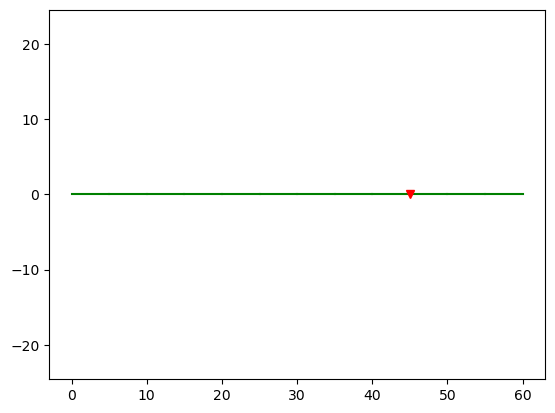

In [5]:
# plot the undeformed wire
plt.figure()
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])

    plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], 'g')
    
# plot the supports
plt.plot(D, 0, 'vr')
plt.axis('equal')

Note that the distance between supports is smaller than the string length. Therefore, the final string position will take a catenary shape between these two points.

## Step 2: Dynamic system:

In this tutorial we assume that we have a string that initially is at its static equilibrium position. Then, we add a mass on the left of the string and release the left support.

#### Step 2.1: Find the initial static position

In order to get the initial string shape, we solve a static problem as done in tutorial 8.

Iteration: 1 ...







Iteration: 2 ...





Iteration: 3 ...


Iteration: 4 ...

Iteration: 5 ...

Iteration: 6 ...

Iteration: 7 ...

Iteration: 8 ...

Iteration: 9 ...

Iteration: 10 ...

Iteration: 11 ...

Iteration: 12 ...

Iteration: 13 ...

Iteration: 14 ...

Iteration: 15 ...

Iteration: 16 ...

Iteration: 17 ...

Iteration: 18 ...

Converged solution at iteration: 18


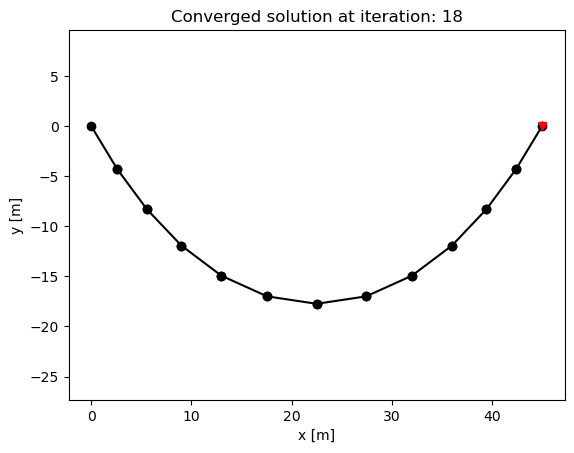

In [6]:
nDof = 2*nNode                          # number of DOFs
FreeDof = np.arange(0, nDof)            # free DOFs 
FixedDof = [0,1, -2, -1]                # fixed DOFs
FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = FreeDof[:, np.newaxis]
fy = FreeDof[np.newaxis, :]

SAG = 20                            # Let us assume a big sag - this will assure that all elements
                                    # are under tension, which may be necesary for the convergence
                                    # of the solver
s = np.array([i[0] for i in NodeCoord])
x = D*(s/L)
y = -4*SAG*((x/D)-(x/D)**2)
u = np.zeros((nDof))
u[0:nDof+1:2] = x - np.array([i[0] for i in NodeCoord])
u[1:nDof+1:2] = y - np.array([i[1] for i in NodeCoord])
# The displacement of the node corresponds to the actual position minus the initial position
# Remember that we use a Global Coordinate System (GCS) here.

Pext = np.zeros((nDof))
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    l0 = Element[iElem, 4]
    m = Element[iElem, 2]
    Pelem = -g*l0*m/2           # Half weight to each node
    Pext[DofsLeft + 1] += Pelem
    Pext[DofsRight + 1] += Pelem

from module_imports.StringForcesAndStiffness import StringForcesAndStiffness
# Convergence parameters
CONV = 0
PLOT = False
kIter = 0
nMaxIter = 100
TENSION = np.zeros((nElem))

while CONV == 0:
    kIter += 1
    print("Iteration: "+str(kIter)+" ...\n")
    # Check stability - define a number of maximum iterations. If solution
    # hasn't converged, check what is going wrong (if something).
    if kIter > nMaxIter:
        break
    
    # Assemble vector with internal forces and stiffnes matrix
    K = np.zeros((nDof*nDof)) 
    Fi = np.zeros((nDof))
    for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                    [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
        Fi_elem, K_elem, Tension, WARN = StringForcesAndStiffness(NodePos, EA, l0, TENSION_ONLY)
        TENSION[iElem] = Tension


        if WARN:
            print("WARNING: Element "+str(iElem+1)+" is under compression.\n")
        
        Fi[DofsLeft:DofsLeft + 2] += Fi_elem[0]
        Fi[DofsRight:DofsRight + 2] += Fi_elem[1]

        # Assemble the matrices at the correct place
            # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
        nodes = np.append(Dofs_Left , Dofs_Right)
        for i in np.arange(0, 4):
            for j in np.arange(0, 4):
                ij = nodes[i] + nodes[j]*nDof
                K[ij] = K[ij] + K_elem[i, j]

    K = K.reshape((nDof, nDof))

    # Calculate residual forces
    R = Pext - Fi

    # Check for convergence
    if np.linalg.norm(R[FreeDof])/np.linalg.norm(Pext[FreeDof]) < 1e-3:
        CONV = 1

    # Calculate increment of displacements
    du = np.zeros((nDof))
    du[FreeDof] = np.linalg.solve(K[fx, fy], R[FreeDof])

    # Apply archlength to help with convergence
    Scale = np.min(np.append(np.array([1]), lElem/np.max(np.abs(du))))
    du = du*Scale   # Enforce that each node does not displace
                    # more (at each iteration) than the length
                    # of the elements

    # Update displacement of nodes
    u += du

    # plot the updated configuration
    if PLOT:
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
        # plot the supports
        plt.plot([0, D], [0, 0], 'vr')
        plt.axis('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Iteration: "+str(kIter))
        plt.pause(0.05)

if CONV == 1:
    print("Converged solution at iteration: "+str(kIter))
    for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
    # plot the supports
    plt.plot(D, 0, 'vr')
    plt.axis('equal')
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Converged solution at iteration: "+str(kIter))
else:
    print("Solution did not converge")

#### Step 2.2: solve the dynamic problem

First, we define the mass on the left node and some damping. 

In [7]:
Mass = 100
C = 0.001*EA

The external force will be the same as the one used to find the initial position, so here we only need to compute the mass matrix.

In [8]:
M = np.zeros((nDof*nDof))
M[0] = Mass                         # Add mass at the left node
M[nDof + 1] = Mass                  # Add mass at the left node
Pext[1] = Pext[1] - Mass*g          # Add weight to the left node
for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        M_elem = m*l0/6*np.array([[2, 0, 1, 0], 
                                    [0, 2, 0, 1], 
                                    [1, 0, 2, 0], 
                                    [0, 1, 0, 2]])
        # Assemble the matrices at the correct place
        # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
        nodes = np.append(Dofs_Left , Dofs_Right)
        for i in np.arange(0, 4):
            for j in np.arange(0, 4):
                ij = nodes[i] + nodes[j]*nDof
                M[ij] = M[ij] + M_elem[i, j]
M = M.reshape((nDof, nDof))

We define the fixed and free DOFs of the system.

In [9]:
# Release the left support
nDof = 2*nNode                          # number of DOFs
FreeDof = np.arange(0, nDof)            # free DOFs 
FixedDof = [-2, -1]                     # fixed DOFs
FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = FreeDof[:, np.newaxis]
fy = FreeDof[np.newaxis, :]

Now, we have all we need to perform the time integration. We initialize the state vector with zero initial velocities. To solve the ODE we use the `solve_ivp` function, calling the `ACCELERATIONS` function as an ode function. You can find the definition of this function below.

##### Auxiliar function:

The `ACCELERATIONS` function computes the accelerations based on the equation:

$$ \bold{M} \ddot{\bold{u}}_{n+1} = \bold{F}_{ext} - \bold{F}_{int}(\bold{u}_n, \dot{\bold{u}}_n) $$

In [10]:
from StringDynamicForces import StringDynamicForces
def ACCELERATIONS(t, U, NodeCoord, Element, FreeDof, C, M, Pext, TENSION_ONLY):
    nDof = len(U)
    u = U[:nDof//2]
    v = U[nDof//2:]

    # free & fixed array indices
    fx = FreeDof[:, np.newaxis]
    fy = FreeDof[np.newaxis, :]

    # Calculate internal forces
    FintDyn = np.zeros((nDof))
    for iElem in np.arange(0, len(Element)):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
            [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
        NodeVel = ([v[DofsLeft], v[DofsRight]], 
                    [v[DofsLeft + 1], v[DofsRight + 1]])
        Fint = StringDynamicForces(NodePos, NodeVel, EA, C, l0)
        FintDyn[DofsLeft:DofsLeft + 2] += Fint[0]
        FintDyn[DofsRight:DofsRight + 2] += Fint[1]

    # Calculate the new acceleration
    a = np.zeros((nDof//2))
    a[FreeDof] = np.linalg.solve(M[fx, fy], (Pext[FreeDof]-FintDyn[FreeDof]))
    
    # Store the derivative of phase
    dU = np.append(v, a)
    #print("Time = "+str(t)+" s")
    return dU


ModuleNotFoundError: No module named 'StringDynamicForces'

In [11]:
v = u*0
U0 = np.append(u, v)
dt = 0.1
Tend = 10
tspan = np.arange(0, Tend, dt)

def odefun(t, U):
    print(t)
    return ACCELERATIONS(t, U, NodeCoord, Element, FreeDof, C, M, Pext, TENSION_ONLY)

sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=U0, t_eval=tspan)  

0.0
3.6452049099210875e-06
7.290409819842176e-05
0.00010935614729763262
0.00029161639279368703
0.0003240182142152078
0.00036452049099210875
0.00036452049099210875
0.0008263431048055731
0.0010572544117123052
0.002211810946245966
0.002417065441274172
0.00267363356005943
0.00267363356005943
0.0031195498517392816
0.0033425079975792074
0.004457298726778837
0.004655483745303215
0.004903215018458688
0.004903215018458688
0.005309758079966885
0.0055130296107209825
0.006529387264491473
0.0067100730696062275
0.00693593032599967
0.00693593032599967
0.007419477578196613
0.007661251204295085
0.008870119334787444
0.009085029224652751
0.009353666586984387
0.009353666586984387
0.00986260041539271
0.010117067329596871
0.011389401900617682
0.011615594713243601
0.011898335729026004
0.011898335729026004
0.012467582604842355
0.012752206042750529
0.014175323232291405
0.014428321843765336
0.014744570108107754
0.014744570108107754
0.015341051820973891
0.01563929267740696
0.017130496959572306
0.0173955999430683

0.3970781142394293
0.4003416311865758
0.40092181197717963
0.4016470379654344
0.4016470379654344
0.3962553923294797
0.39682308645864883
0.3996615571044946
0.4001661741082005
0.4007969453628329
0.4007969453628329
0.40192647749915217
0.4024912435673118
0.40531507390810995
0.4058170881909185
0.4064446060444292
0.4064446060444292
0.4016733375481843
0.40211153364085994
0.4043025141042384
0.4046920217421724
0.4051789062895898
0.4051789062895898
0.4060552984749412
0.40649349456761685
0.4086844750309953
0.4090739826689293
0.4095608672163467
0.4095608672163467
0.4108285279528428
0.4114623583210909
0.4146315101623312
0.4151949149341072
0.4158991708988273
0.4158991708988273
0.41789342453152933
0.4188905513478804
0.42387618542963557
0.4247625203775031
0.4258704390623376
0.4258704390623376
0.4167963466360086
0.4172449345045993
0.4194878738475527
0.4198866186196333
0.42038504958473405
0.42038504958473405
0.4212446781281214
0.4216744923998151
0.4238235637582835
0.42420562088867786
0.42468319230167084


0.7911110886100727
0.7911110886100727
0.7858087877117034
0.7861575212311578
0.78790118882843
0.7882111741790561
0.7885986558673388
0.7885986558673388
0.7892961229062476
0.789644856425702
0.7913885240229742
0.7916985093736003
0.792085991061883
0.792085991061883
0.7929615648163396
0.793399351693568
0.7955882860797096
0.7959774299705791
0.7964638598341661
0.7964638598341661
0.7976661511407702
0.7982672967940723
0.8012730250605824
0.8018073767524064
0.8024753163671865
0.8024753163671865
0.8036872649983822
0.80429323931398
0.8073231108919693
0.8078617547280562
0.808535059523165
0.808535059523165
0.8033782503257992
0.8038297173051056
0.8060870522016372
0.8064883561832429
0.80698998616025
0.80698998616025
0.8078929201188627
0.808344387098169
0.8106017219947007
0.8110030259763064
0.8115046559533134
0.8115046559533134
0.8129808301956435
0.8137189173168085
0.8174093529226336
0.8180654303636692
0.8188855271649637
0.8188855271649637
0.8202394729348889
0.8209164458198513
0.8243013102446642
0.824903

1.1508057141952541
1.1508057141952541
1.1516862502551897
1.1521265182851574
1.154327858434996
1.1547192077949675
1.1552083944949316
1.1552083944949316
1.1562875419458458
1.156827115671303
1.1595249842985884
1.1600046053878836
1.1606041317495026
1.1606041317495026
1.1619315220265376
1.1625952171650549
1.1659136928576421
1.16650364409188
1.1672410831346771
1.1672410831346771
1.1617122238822448
1.162266269948616
1.1650365002804717
1.1655289856728015
1.1661445924132139
1.1661445924132139
1.16725004744567
1.167802774961898
1.1705664125430382
1.1710577258907964
1.1716718675754942
1.1716718675754942
1.1670426765388424
1.1674917186016567
1.1697369289157278
1.1701360774160072
1.1706350130413563
1.1706350130413563
1.1715330971669848
1.171982139229799
1.1742273495438702
1.1746264980441496
1.1751254336694987
1.1751254336694987
1.176498756222218
1.1771854174985774
1.1806187238803754
1.1812290894593618
1.1819920464330946
1.1819920464330946
1.183469102310582
1.1842076302493258
1.1879002699430445
1.18

1.4884468644326982
1.489399283161106
1.48987549252531
1.4922565393463296
1.4926798365589553
1.4932089580747374
1.4932089580747374
1.4941060040868688
1.4945545270929343
1.4967971421232626
1.4971958292397656
1.497694188135394
1.497694188135394
1.4988311440237148
1.4993996219678754
1.5022420116886774
1.50274732541682
1.5033789675769982
1.5033789675769982
1.5049015642954622
1.505662862654694
1.5094693544508537
1.5101460641035045
1.5109919511693177
1.5109919511693177
1.504192402736076
1.5045991203156148
1.5066327082133093
1.5069942349506773
1.5074461433723871
1.5074461433723871
1.508259578531465
1.5086662961110038
1.5106998840086983
1.5110614107460663
1.511513319167776
1.511513319167776
1.5125977677117912
1.513139991983799
1.5158511133438366
1.51633309047451
1.5169355618878517
1.5169355618878517
1.518187531689987
1.5188135165910548
1.5219434410963932
1.5224998721195646
1.5231954108985286
1.5231954108985286
1.524568709537876
1.5252553588575495
1.528688605455918
1.5292989604067388
1.530061904

1.8528458802356143
1.8534771728415431
1.8534771728415431
1.8546043574144317
1.855167949700876
1.8579859111330974
1.8584868820543812
1.859113095705986
1.859113095705986
1.85432633858465
1.8547509214562037
1.8568738358139711
1.8572512428109076
1.857723001557078
1.857723001557078
1.858572167300185
1.8589967501717386
1.861119664529506
1.8614970715264425
1.861968830272613
1.861968830272613
1.863146109298895
1.863734748812036
1.8666779463777408
1.867201181500533
1.8678552254040228
1.8678552254040228
1.869252637107255
1.8699513429588714
1.8734448722169523
1.8740659440850556
1.8748422839201846
1.8748422839201846
1.8687974791441704
1.869268606014244
1.871624240364613
1.8720430198046787
1.8725664941047606
1.8725664941047606
1.8735087478449082
1.873979874714982
1.8763355090653508
1.8767542885054165
1.8772777628054984
1.8772777628054984
1.878310650516695
1.8788270943722933
1.881409313650285
1.8818683748552614
1.8824422013614817
1.8824422013614817
1.8839504477727158
1.8847045709783328
1.88847518700

2.2282331702660523
2.231664000634096
2.2322739260328595
2.233036332781314
2.233036332781314
2.2272178317116262
2.2277394115448264
2.2303473107108274
2.230810937229228
2.231390470377228
2.231390470377228
2.2324336300436287
2.232955209876829
2.23556310904283
2.2360267355612304
2.2366062687092305
2.2366062687092305
2.237560351947691
2.2380373935669216
2.2404226016630733
2.2408466386579446
2.241376684901534
2.241376684901534
2.2424681342063315
2.2430138588587303
2.245742482120724
2.246227570700634
2.2468339314255217
2.2468339314255217
2.2422526897339807
2.2426906921502043
2.244880704231322
2.2452700397124095
2.2457567090637687
2.2457567090637687
2.2466327138962154
2.247070716312439
2.2492607283935566
2.249650063874644
2.2501367332260034
2.2501367332260034
2.2511876288527177
2.2517130766660753
2.2543403157328616
2.2548073804558455
2.255391211359576
2.255391211359576
2.256662656181867
2.2572983785930125
2.2604769906487405
2.2610420772364255
2.2617484354710315
2.2617484354710315
2.26291631148

2.596579545588488
2.5991911087741797
2.599655386673858
2.6002357340484563
2.6002357340484563
2.601448964082133
2.602055579098972
2.6050886541831644
2.605627867531465
2.6063018842168413
2.6063018842168413
2.6011817601262335
2.601654773165122
2.6040198383595645
2.604440294394132
2.6049658644373417
2.6049658644373417
2.605911890515119
2.6063849035540074
2.60874996874845
2.6091704247830174
2.609695994826227
2.609695994826227
2.6110868968207157
2.6117823478179596
2.615259602804181
2.6158777814683982
2.6166505047986695
2.6166505047986695
2.610839678166963
2.611411519837331
2.614270728189171
2.614779031896165
2.615414411529907
2.615414411529907
2.6165403062562778
2.617103253619463
2.6199179904353893
2.6204183880915544
2.62104388516176
2.62104388516176
2.6162874923643504
2.616724032781572
2.6189067348676813
2.6192947707941006
2.619779815702125
2.619779815702125
2.6206528965365683
2.62108943695379
2.623272139039899
2.6236601749663184
2.6241452198743427
2.6241452198743427
2.6254375164107024
2.62

2.9230634264157707
2.9238955549384116
2.9243116191997323
2.926391940506335
2.9267617754052866
2.927224069028976
2.927224069028976
2.9287956098470036
2.9295813802560176
2.933510232301087
2.934208694886877
2.9350817731191143
2.9350817731191143
2.9372731310338
2.938368809991143
2.943847204777858
2.9448211416288292
2.946038562692544
2.946038562692544
2.935866636558066
2.936259068277542
2.938221226874921
2.9385700550700107
2.939006090313873
2.939006090313873
2.9397909537528246
2.9401833854723005
2.9421455440696795
2.942494372264769
2.9429304075086313
2.9429304075086313
2.944238120562556
2.944891977089518
2.9481612597243285
2.948742465526073
2.949468972778253
2.949468972778253
2.9508874541492447
2.9515966948347403
2.955142898262219
2.9557733344271044
2.956561379633211
2.956561379633211
2.9579109972980686
2.9585858061304973
2.9619598502926414
2.9625596803659118
2.963309467957499
2.963309467957499
2.957173347661584
2.9574793316757706
2.9590092517467035
2.9592812375370916
2.9596212197750766
2.9

3.3306253469759053
3.331801796139827
3.331801796139827
3.3227559851520945
3.323527100895877
3.327382679614787
3.328068115831482
3.328924911102351
3.328924911102351
3.330467142589915
3.3312382583336975
3.3350938370526078
3.335779273269303
3.3366360685401717
3.3366360685401717
3.3302055000840527
3.3308457945749033
3.3340472670291565
3.3346164176876907
3.335327856010858
3.335327856010858
3.3366084449925597
3.3372487394834103
3.3404502119376636
3.3410193625961977
3.341730800919365
3.341730800919365
3.3434243129195234
3.344271068919603
3.348504848919999
3.349257520920069
3.350198360920157
3.350198360920157
3.351944549584225
3.352817643916259
3.357183115576428
3.3579591994271247
3.3589293042404957
3.3589293042404957
3.351767839688751
3.352552579073048
3.3564762759945324
3.3571738221139076
3.3580457547631264
3.3580457547631264
3.3596152335317204
3.360399972916017
3.3643236698375016
3.365021215956877
3.3658931486060957
3.3658931486060957
3.367370944180154
3.368109841967183
3.3718043309023287
3

3.9892913746495
3.9907844222053543
3.9910498528819507
3.991381641227696
3.991381641227696
3.992160981706206
3.9925506519454608
3.994499003141735
3.9948453766877394
3.995278343620245
3.995278343620245
3.9963729536530432
3.996920258669442
3.9996567837514374
4.0001432770993475
4.000751393784236
4.000751393784236
4.001800378134183
4.002324870309156
4.004947331184023
4.005413546450666
4.00599631553397
4.00599631553397
4.006952563248421
4.007430687105646
4.009821306391775
4.010246305375976
4.010777554106226
4.010777554106226
4.01188687068071
4.012441528967952
4.015214820404162
4.015707849992822
4.016324136978646
4.016324136978646
4.017360577806075
4.017878798219789
4.0204699002883615
4.020930540656107
4.02150634111579
4.02150634111579
4.022511667040023
4.023014330002139
4.025527644812722
4.025974456334603
4.026532970736954
4.026532970736954
4.022361916059308
4.022789703531067
4.02492864088986
4.025308896420312
4.025784215833378
4.025784215833378
4.026639790776895
4.027067578248654
4.02920651

4.289267544765616
4.2895535794706525
4.2895535794706525
4.290066489154577
4.290322943996539
4.291605218206351
4.291833178065873
4.292118127890276
4.292118127890276
4.292701734153066
4.292993537284461
4.294452552941438
4.294711933502678
4.295036159204229
4.295036159204229
4.296025666947073
4.296520420818496
4.298994190175606
4.299433971394648
4.29998369791845
4.29998369791845
4.295913381602382
4.296351992801459
4.298545048796844
4.298934925418245
4.299422271194997
4.299422271194997
4.30029949359315
4.300738104792227
4.302931160787612
4.303321037409013
4.303808383185765
4.303808383185765
4.304659114023419
4.305084479442247
4.307211306536383
4.3075894091308955
4.308062037374037
4.308062037374037
4.308900124774994
4.309319168475473
4.311414386977867
4.3117868702671815
4.312252474378824
4.312252474378824
4.313106749483614
4.31353388703601
4.315669574797986
4.316049252622337
4.316523849902776
4.316523849902776
4.317361473939998
4.31778028595861
4.319874346051667
4.320246623401544
4.320711970

4.673541139816108
4.674354676736119
4.674761445196124
4.676795287496151
4.6771568594606
4.677608824416161
4.677608824416161
4.678428512563651
4.678838356637396
4.680887577006121
4.68125188284945
4.681707265153611
4.681707265153611
4.682465303458197
4.68284432261049
4.684739418371953
4.6850763242851015
4.685497456676538
4.685497456676538
4.686225821432406
4.686590003810339
4.688410915700009
4.688734633369284
4.689139280455877
4.689139280455877
4.6899109101106005
4.690296724937961
4.692225799074769
4.692568745587979
4.692997428729492
4.692997428729492
4.693789084407193
4.694184912246044
4.696164051440296
4.696515898408163
4.696955707117997
4.696955707117997
4.697765693324094
4.698170686427143
4.700195651942385
4.700555645811761
4.701005638148482
4.701005638148482
4.701834802485812
4.702249384654477
4.704322295497803
4.7046908129810605
4.7051514598351325
4.7051514598351325
4.705992914397096
4.706413641678077
4.708517278082986
4.708891257888303
4.709358732644949
4.709358732644949
4.7101794

5.08876798639545
5.089169403000532
5.091176486025941
5.091533300786014
5.091979319236105
5.091979319236105
5.092914267219466
5.093381741211146
5.095719111169547
5.096134643606596
5.0966540591529075
5.0966540591529075
5.097700960533281
5.098224411223467
5.1008416646744
5.101306954176788
5.1018885660547735
5.1018885660547735
5.103006806518958
5.103565926751051
5.106361527911513
5.106858523673373
5.107479768375698
5.107479768375698
5.102666874718674
5.103056029050624
5.105001800710374
5.105347715672107
5.105780109374274
5.105780109374274
5.1065584180381745
5.1069475723701245
5.108893344029875
5.109239258991608
5.109671652693775
5.109671652693775
5.110491453364346
5.110901353699631
5.112950855376056
5.113315211229643
5.1137706560466265
5.1137706560466265
5.114664734952281
5.115111774405108
5.117346971669244
5.117744340071757
5.118241050574898
5.118241050574898
5.119119510306414
5.119558740172172
5.121754889500961
5.122145316048302
5.122633349232477
5.122633349232477
5.123643946953155
5.124

5.5438373515737505
5.544317591269858
5.546718789750396
5.547145669480269
5.547679269142611
5.547679269142611
5.548639748534826
5.549119988230934
5.551521186711471
5.551948066441344
5.552481666103686
5.552481666103686
5.553545528534518
5.554077459749934
5.556737115827014
5.55720994357405
5.557800978257846
5.557800978257846
5.558915848104605
5.559473283027984
5.562260457644881
5.562755955354552
5.563375327491641
5.563375327491641
5.564432210725146
5.564960652341899
5.567602860425662
5.56807258630722
5.568659743659167
5.568659743659167
5.569873856804985
5.570480913377894
5.573516196242438
5.574055802085023
5.574730309388255
5.574730309388255
5.569616702364923
5.5700951817178
5.572487578482188
5.572912893462524
5.573444537187943
5.573444537187943
5.574373559598749
5.574838070804152
5.577160626831167
5.577573525680414
5.5780896492419725
5.5780896492419725
5.579144679553294
5.579672194708955
5.58230977048726
5.582778672847847
5.583364800798582
5.583364800798582
5.584553659286309
5.5851480885

6.011912903867436
6.0123440806756685
6.01288305168596
6.01288305168596
6.013894810101339
6.014400689309029
6.016930085347476
6.017379755754312
6.017941843762856
6.017941843762856
6.019000926644981
6.019530468086045
6.02217817529136
6.022648878794527
6.023237258173486
6.023237258173486
6.02436285037532
6.024925646476237
6.027739626980821
6.028239890181637
6.028865219182656
6.028865219182656
6.0301525645381275
6.0307962372158626
6.034014600604541
6.034586754095862
6.035301945960013
6.035301945960013
6.036485418274771
6.037077154432151
6.040035835219046
6.040561822914494
6.0412193075338045
6.0412193075338045
6.036159001717955
6.036587529596926
6.038730168991782
6.039111082661978
6.039587224749724
6.039587224749724
6.040444280507666
6.040872808386637
6.043015447781492
6.043396361451689
6.0438725035394345
6.0438725035394345
6.040324941063798
6.040693799220834
6.042538090006017
6.042865963923384
6.043275806320091
6.043275806320091
6.044013522634165
6.044382380791201
6.046226671576385
6.04655

6.4325845980457705
6.4349876262478825
6.435414831261591
6.435948837528727
6.435948837528727
6.436932707028115
6.437424641777808
6.439884315526276
6.440321590859337
6.440868185025664
6.440868185025664
6.436832528306388
6.437274373695218
6.439483600639371
6.4398763520961095
6.440367291417032
6.440367291417032
6.441250982194693
6.441692827583523
6.443902054527676
6.4442948059844145
6.444785745305337
6.444785745305337
6.445876425662632
6.44642176584128
6.449148466734518
6.4496332135599825
6.450239147091813
6.450239147091813
6.451273073005968
6.451790035963046
6.454374850748434
6.454834373376947
6.455408776662589
6.455408776662589
6.451115914352037
6.451554297982149
6.45374621613271
6.454135890470587
6.454622983392934
6.454622983392934
6.455499750653158
6.4559381342832705
6.45813005243383
6.458519726771708
6.459006819694054
6.459006819694054
6.460152106567184
6.460724750003749
6.463587967186574
6.464096983574632
6.464733254059704
6.464733254059704
6.465793974386551
6.466324334549974
6.46897

6.746100163784147
6.748209429606562
6.748584410197213
6.749053135935528
6.749053135935528
6.749879895360107
6.750293275072396
6.752360173633844
6.75272762226699
6.753186933058423
6.753186933058423
6.7540995748138
6.754555895691489
6.756837500079931
6.757243118637877
6.7577501418353085
6.7577501418353085
6.7588103066433245
6.759340389047332
6.7619908010673715
6.76246198542649
6.7630509658753875
6.7630509658753875
6.7642215491423
6.764806840775755
6.7677332989430345
6.768253558172773
6.768903882209947
6.768903882209947
6.770212617161471
6.770866984637233
6.774138822016043
6.774720481994498
6.775447556967567
6.775447556967567
6.770043494463266
6.770613300589925
6.773462331223223
6.773968825558032
6.774601943476543
6.774601943476543
6.775741555729862
6.776311361856521
6.779160392489819
6.779666886824628
6.780300004743139
6.780300004743139
6.775623516379139
6.776134302830437
6.778688235086928
6.779142267488083
6.779709807989525
6.779709807989525
6.780731380892121
6.781242167343419
6.7837960

7.0172068137152115
7.017505789873346
7.0190006706640204
7.019266427249029
7.01959862298029
7.01959862298029
7.020391241727622
7.0207875511012885
7.02276909796962
7.0231213729684345
7.023561716716952
7.023561716716952
7.020207608652554
7.020512101488686
7.0220345656693475
7.022305225968132
7.022643551341612
7.022643551341612
7.023246966360364
7.0235486738697395
7.025057211416618
7.025325395869396
7.02566062643537
7.02566062643537
7.023180494474269
7.023448966040597
7.024791323872239
7.0250299652645305
7.0253282670048955
7.0253282670048955
7.025865210137552
7.026133681703881
7.0274760395355225
7.027714680927814
7.028012982668179
7.028012982668179
7.025806284023461
7.026045292532743
7.0272403350791555
7.027452787087407
7.027718352097721
7.027718352097721
7.028196369116286
7.028435377625568
7.029630420171981
7.029842872180232
7.030108437190546
7.030108437190546
7.030648834963095
7.0309190338493694
7.032270028280742
7.032510205068541
7.032810426053291
7.032810426053291
7.033380392089879
7.0

7.259171141040882
7.259668675513022
7.262156347873721
7.262598600737845
7.263151416818
7.263151416818
7.264179961983481
7.264694234566222
7.267265597479924
7.267722728664582
7.268294142645405
7.268294142645405
7.263878219625074
7.26424162102861
7.266058628046294
7.266381651516105
7.266785430853368
7.266785430853368
7.267512233660441
7.267875635063978
7.269692642081662
7.2700156655514725
7.270419444888735
7.270419444888735
7.271262051271325
7.27168335446262
7.273789870419094
7.274164362144689
7.274632476801684
7.274632476801684
7.275419243154597
7.275812626331055
7.277779542213339
7.278129216147967
7.278566308566252
7.278566308566252
7.279310509553078
7.279682610046491
7.281543112513555
7.2818738685077
7.2822873135003805
7.2822873135003805
7.283008930956358
7.283369739684347
7.285173783324291
7.285494502193615
7.2858954007802685
7.2858954007802685
7.286704728637026
7.287109392565404
7.289132712207298
7.289492413476967
7.289942040064055
7.289942040064055
7.2908607953214215
7.291320172950

7.611544781067862
7.6131902352196255
7.613482760402161
7.613848416880331
7.613848416880331
7.614497757109825
7.6148224272245715
7.616445777798305
7.6167343734558575
7.617095118027798
7.617095118027798
7.61774706439997
7.618073037586056
7.619702903516487
7.619992657459674
7.620354849888659
7.620354849888659
7.621154132275363
7.621553773468714
7.623551979435473
7.623907216051786
7.624351261822177
7.624351261822177
7.620957227578196
7.621258416422965
7.6227643606468085
7.623032084064381
7.623366738336346
7.623366738336346
7.623936350271012
7.624221156238344
7.625645186075009
7.625898346934861
7.626214798009675
7.626214798009675
7.626888484734613
7.62722532809708
7.628909544909423
7.629208961231617
7.62958323163436
7.62958323163436
7.63044014123376
7.63086859603346
7.633010870031962
7.633391718742806
7.633867779631362
7.633867779631362
7.634650341333476
7.635041622184533
7.636998026439819
7.637345831640759
7.637780588141934
7.637780588141934
7.6386600817185135
7.639099828506803
7.641298562

7.855373792229107
7.855373792229107
7.856129659303748
7.856507592841068
7.858397260527671
7.858733201449732
7.859153127602311
7.859153127602311
7.860210956265123
7.860739870596528
7.863384442253556
7.863854588325917
7.864442270916368
7.864442270916368
7.865539768768676
7.8660885176948305
7.868832262325601
7.869320039148849
7.869929760177909
7.869929760177909
7.871057103508933
7.871620775174446
7.8744391335020065
7.874940174982462
7.875566476833031
7.875566476833031
7.870860854415981
7.871326401535017
7.873654137130195
7.874067956791561
7.874585231368267
7.874585231368267
7.875504009047228
7.875963397886708
7.878260342084109
7.878668687719203
7.879179119763069
7.879179119763069
7.8753944142590395
7.875799005704425
7.877821962931355
7.878181599771699
7.878631145822127
7.878631145822127
7.879440328712899
7.879844920158285
7.881867877385215
7.8822275142255585
7.882677060275987
7.882677060275987
7.883687644641566
7.8841929368243555
7.886719397738302
7.887168546345226
7.887729982103881
7.887

8.134892506943075
8.134892506943075
8.135347463531797
8.135574941826158
8.136712333297963
8.136914536226284
8.137167289886685
8.137167289886685
8.137782800653977
8.138090556037621
8.13962933295585
8.139902893296869
8.140244843723142
8.140244843723142
8.140872092477249
8.141185716854302
8.142753838739571
8.143032615963618
8.143381087493678
8.143381087493678
8.144266683111596
8.144709480920556
8.146923469965351
8.14731706801776
8.14780906558327
8.14780906558327
8.148750057050233
8.149220552783714
8.15157303145112
8.151991249880881
8.152514022918083
8.152514022918083
8.153611727745506
8.154160580159216
8.156904842227771
8.157392711039959
8.158002547055194
8.158002547055194
8.159155491898977
8.15973196432087
8.162614326430328
8.163126746360899
8.16376727127411
8.16376727127411
8.16503421751613
8.16566769063714
8.168835056242186
8.16939814346086
8.170102002484205
8.170102002484205
8.171304380464273
8.171905569454308
8.17491151440448
8.175445904617844
8.176113892384548
8.176113892384548
8.17

8.535517409489021
8.535517409489021
8.536605987787231
8.537150276936337
8.539871722681866
8.540355535258849
8.540960300980077
8.540960300980077
8.542052440573423
8.542598510370096
8.54532885935346
8.545814254728281
8.546420998946807
8.546420998946807
8.54752916926304
8.548083254421156
8.550853680211736
8.551346200352285
8.551961850527968
8.551961850527968
8.553087373594153
8.553650135127244
8.556463942792703
8.556964175266563
8.557589465858888
8.557589465858888
8.558729617169305
8.559299692824514
8.562150071100556
8.562656805016298
8.563290222410973
8.563290222410973
8.564439585353329
8.565014266824505
8.56788767418039
8.568398502154771
8.569037037122746
8.569037037122746
8.570199213562773
8.570780301782786
8.573685742882857
8.574202265745091
8.574847919322885
8.574847919322885
8.576006804672888
8.576586247347889
8.579483460722896
8.579998520878453
8.5806423460729
8.5806423460729
8.58176049524612
8.582319569832732
8.585114942765786
8.585611897953884
8.586233091939008
8.586233091939008


8.992339131383586
8.994007040465375
8.99430355763547
8.994674204098091
8.994674204098091
8.995341367730807
8.995674949547164
8.997342858628953
8.997639375799048
8.998010022261669
8.998010022261669
8.998764313842829
8.999141459633407
9.001027188586304
9.001362429289042
9.001781480167464
9.001781480167464
9.002631867054928
9.00305706049866
9.005183027717322
9.005560977445084
9.006033414604786
9.006033414604786
9.006942834710735
9.00739754476371
9.009671095028583
9.010075281742338
9.010580515134532
9.010580515134532
9.011518565208647
9.011987590245706
9.014332715430996
9.014749626575046
9.015270765505111
9.015270765505111
9.01621453105438
9.016686413829015
9.019045827702191
9.019465279057423
9.019989593251461
9.019989593251461
9.020918457282301
9.02138288929772
9.023705049374822
9.024117877832973
9.024633913405662
9.024633913405662
9.02553214982536
9.025981268035208
9.02822685908445
9.028626075270981
9.029125095504147
9.029125095504147
9.029978299552885
9.030404901577255
9.032537911699098

9.295119945583126
9.295513730300526
9.296005961197274
9.296005961197274
9.296900073568745
9.297347129754481
9.299582410683158
9.299979793959366
9.300476523054629
9.300476523054629
9.301377752809998
9.301828367687682
9.304081442076104
9.304481988634047
9.304982671831473
9.304982671831473
9.305890066869901
9.306343764389116
9.308612251985185
9.30901553866893
9.309519647023613
9.309519647023613
9.31043224494055
9.310888543899019
9.313170038691363
9.313575637765556
9.3140826366083
9.3140826366083
9.314999418172306
9.31545780895431
9.317749762864326
9.318157221337218
9.318666544428332
9.318666544428332
9.319586399441867
9.320046326948637
9.322345964482476
9.322754788932937
9.323265819496012
9.323265819496012
9.324187549201554
9.324648414054323
9.326952738318177
9.327362395965086
9.327874468023719
9.327874468023719
9.328796820494565
9.329257996729988
9.331563877907103
9.33197381233859
9.332486230377949
9.332486230377949
9.333407950195227
9.333868810103867
9.336173109647063
9.336582762899187


9.650130317735108
9.650130317735108
9.651009180907147
9.651448612493168
9.653645770423266
9.654036376277505
9.654524633595305
9.654524633595305
9.655403916078477
9.655843557320063
9.658041763527992
9.658432555742735
9.658921046011164
9.658921046011164
9.659782272703374
9.66021288604948
9.662365952780007
9.662748720198767
9.663227179472218
9.663227179472218
9.664086711196214
9.664516477058214
9.666665306368207
9.667047320467761
9.667524838092204
9.667524838092204
9.668368352486635
9.668790109683849
9.670898895669923
9.671273790956338
9.671742410064354
9.671742410064354
9.67257994891356
9.672998718338164
9.675092565461181
9.675464804949717
9.675930104310387
9.675930104310387
9.676749585939287
9.677159326753737
9.679208030825986
9.679572244883275
9.680027512454886
9.680027512454886
9.680831970589242
9.681234199656421
9.683245344992313
9.683602881940915
9.684049803126669
9.684049803126669
9.684826766555346
9.685215248269685
9.68715765684138
9.687502973920793
9.687934620270058
9.68793462027

Once we have the solution, we can plot the evolution of the string.

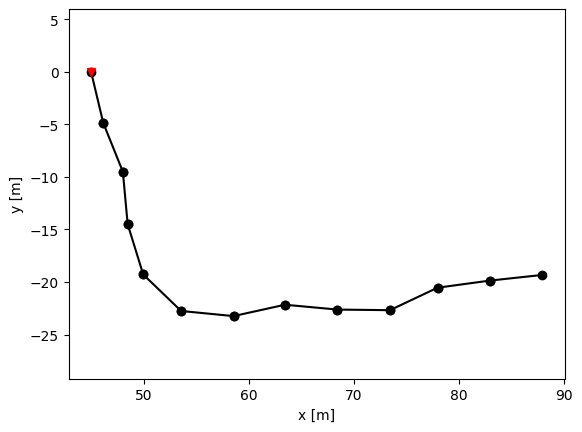

In [12]:
%matplotlib inline
import time
from IPython import display

for iT in np.arange(0, len(sol.t)):
    try: 
        u = sol.y[:nDof, iT]
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
        # plot the supports
        plt.plot(D, 0, 'vr')     
        plt.axis('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.clf()
        time.sleep(0.01)
    except KeyboardInterrupt:
        break

u = sol.y[:nDof, -1]
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
# plot the supports
plt.plot(D, 0, 'vr') 
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]");